<a href="https://colab.research.google.com/github/vvitzilaios/carPricePrediction/blob/main/usedCarPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Used Cars Price Prediction

### Libraries and Modules

1. **datetime**: Provides functions and classes for manipulating dates and times.
2. **pandas**: Data manipulation and analysis library, helping in reading datasets and manipulating dataframes.
3. **StandardScaler**: Sklearn's preprocessing tool for scaling features to a standard scale.
4. **numpy**: Fundamental package for numerical computations in Python.
5. **matplotlib & seaborn**: Popular libraries for visualizing data and generating plots.
6. **RandomForestRegressor, Ridge, SGDRegressor, KNeighborsRegressor**: Machine learning algorithms for regression analysis.
7. **GridSearchCV**: Sklearn's tool for hyperparameter tuning using cross-validation.
8. **timer**: Measures execution time of small code snippets.
9. **mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error**: Metrics to evaluate regression models' performance.
10. **train_test_split**: Sklearn's tool to split data into training and test sets.


In [2]:
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from timeit import default_timer as timer

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.model_selection import train_test_split, GridSearchCV


## Plots

### Plotting Categorical Counts

The function visualizes the distribution of categories within a specified column by plotting a bar chart that displays the number of occurrences for each category.


In [3]:
def plot_categorical_counts(data, column_name, save_path=None):
    plt.figure(figsize=(20, 10))
    plt.bar(data[column_name].value_counts().index, data[column_name].value_counts())
    plt.xticks(rotation=90)
    plt.xlabel(column_name)
    plt.ylabel("Counts")
    plt.title(f"Number of cars per {column_name}")

    if save_path:
        plt.savefig(save_path)
    plt.show()

### Average Price per Manufacturer

This plot displays a bar chart illustrating the average car price for each manufacturer, helping to gauge which manufacturers typically produce more expensive or affordable vehicles.


In [4]:
def plot_avg_price_per_manufacturer(data, save_path=None):
    avg_prices = data.groupby("Manufacturer")["Price"].mean()
    plt.figure(figsize=(20, 10))
    plt.bar(avg_prices.index, avg_prices)
    plt.xticks(rotation=90)
    plt.xlabel("Manufacturer")
    plt.ylabel("Average Price")
    plt.title("Average price per manufacturer")

    if save_path:
        plt.savefig(save_path)
    plt.show()

### Predictions vs Actual Values Visualization

A scatter plot comparing the actual car prices with the predictions generated by a model. The red dashed line represents the perfect prediction line, where the true values equal the predicted values. This visual


In [5]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot(
        np.linspace(min(y_true), max(y_true), 100),
        np.linspace(min(y_true), max(y_true), 100),
        color="red",
        linestyle="--",
    )

    plt.title(f"{model_name} Predictions vs Actual")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"plots/{model_name.replace(' ', '_')}_predictions_vs_actual.png")
    plt.show()

### Residuals Plot Visualization

This function visualizes the residuals (differences between actual and predicted values) against the predicted values. Ideally, residuals should be randomly scattered around the horizontal axis. A systematic pattern might suggest potential issues with the model, such as heteroscedasticity. The red dashed line at y=0 represents the point where the predicted value matches the actual value.



In [6]:
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.title(f"{model_name} Residuals Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"plots/{model_name.replace(' ', '_')}_residuals.png")
    plt.show()

### Residuals Distribution Visualization

Generates a histogram to visualize the distribution of residuals (differences between actual and predicted values) for a given model. An ideally fitting model would have its residuals normally distributed around zero. This visualization can help in diagnosing potential issues with the model and the assumptions underlying regression.


In [7]:
def residuals_distribution(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"plots/{model_name.replace(' ', '_')}_residuals_distribution.png")
    plt.show()

### Feature Importance Visualization

Generates a horizontal bar chart to display the aggregated importance of each feature. Features are ranked based on their importance, allowing for easy identification of the most influential factors in the model's decision-making process.


In [8]:
def plot_aggregated_importance(aggregated):
    # Sort features based on importance
    sorted_features = sorted(aggregated.items(), key=lambda x: x[1], reverse=True)

    # Unzip the sorted items into two lists
    labels, values = zip(*sorted_features)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(labels, values)
    plt.xlabel("Importance")
    plt.title("Aggregated Feature Importances")
    plt.gca().invert_yaxis()  # To display the most important feature at the top

    plt.savefig(f"plots/aggregated_feature_importance.png")
    plt.show()

### Aggregating Feature Importance

This function consolidates the importance values for features that have undergone one-hot encoding. By summing the importance across all encoded categories for a given feature, it provides a holistic view of that feature's importance in the model.


In [9]:
def aggregate_importance(importance, columns):
    # Create a dictionary to store the aggregated importance
    aggregated = {}

    for col, imp in zip(columns, importance):
        # For each column, find the original feature name (before one-hot encoding)
        # Assuming column names of dummies are like 'FeatureName_Value'
        original_feature = col.split("_")[0]

        if original_feature in aggregated:
            aggregated[original_feature] += imp
        else:
            aggregated[original_feature] = imp

    return aggregated

## Feature Engineering

### Load the Dataset

At this step we load the initial dataset from the .csv file to further manipulate the data.

In [10]:
def __load_data(input_path):
    data = pd.read_csv(input_path)
    return data

### Preprocessing the Dataset

The `__preprocess_features` function plays a pivotal role in the data preprocessing phase of our car price prediction project. This function is specifically designed to make the raw dataset suitable for modeling, and it does so by transforming, adding, and removing certain features. Below is an elucidation of the steps involved:

1. **Deriving Car Age**:
   - Instead of directly using the `Prod. year` column (which indicates the year a car was produced), we find it more meaningful to compute the age of the car. This is done by subtracting the production year from the current year, resulting in a new feature named `Car Age`.
   - Rationale: Car age can be a more intuitive measure when predicting prices since older cars typically depreciate in value.

2. **Dropping Unnecessary Features**:
   - Some columns are deemed to provide little to no value for our prediction task. These include `Prod. year`, `Doors`, `Cylinders`, `ID`, and `Wheel`. These columns are dropped from the dataset.
   - Rationale: Simplifying our dataset by removing features that don't substantially contribute to the prediction can help the model generalize better.

3. **Handling the Levy Feature**:
   - The `Levy` column contains instances where the value is represented as a dash ("-"). We treat these instances by replacing the dash with a 0.
   - The column is then cast to an integer data type.
   - Rationale: By replacing non-numeric entries and ensuring the entire column is of integer type, we ensure that the feature is in a suitable format for modeling.

4. **Engine Volume and Turbo**:
   - The `Engine volume` column contains information about the car's engine volume and also whether the car has a turbocharger (indicated by the string "Turbo").
   - We derive a new binary feature, `Turbo`, which indicates the presence (1) or absence (0) of a turbocharger.
   - Subsequently, the "Turbo" string is removed from the `Engine volume` column, and the column is transformed to a float data type.
   - Rationale: Splitting the engine volume and turbocharger information into two distinct features can allow the model to independently gauge the importance of each.

5. **Converting Mileage**:
   - The `Mileage` column is represented as a string with a " km" suffix. We transform this feature by stripping the " km" suffix and converting the column to an integer data type.
   - Rationale: Transforming mileage to a clean numeric format is essential for modeling, as models require numeric input.

---

By the end of these preprocessing steps, the dataset is transformed into a structured format, making it amenable to training machine learning models. Such preprocessing is fundamental in any data science project, ensuring that the raw data is converted into a meaningful and usable format.

In [11]:
def __preprocess_features(data):
    # Derive 'Car Age'
    data["Car Age"] = data["Prod. year"].apply(lambda x: datetime.now().year - x)

    # Drop unnecessary columns
    columns_to_drop = ["Prod. year", "Doors", "Cylinders", "ID", "Wheel"]
    data.drop(columns=columns_to_drop, inplace=True)

    # Handle Levy
    data["Levy"].replace("-", 0, inplace=True)
    data["Levy"] = data["Levy"].astype(int)

    # Handle 'Engine volume'
    data["Turbo"] = data["Engine volume"].apply(lambda x: 1 if "Turbo" in x else 0)
    data["Engine volume"] = (
        data["Engine volume"].str.replace(" Turbo", "").astype(float)
    )

    # Convert 'Mileage'
    data["Mileage"] = data["Mileage"].str.replace(" km", "").astype(int)

    return data

### Feature Encoding and Scaling

The function `__encode_and_scale_features` is tasked with transforming certain features in the dataset to make them suitable for machine learning modeling. This involves two primary tasks: categorical feature encoding and feature scaling. Here's a breakdown of its operations:

1. **Categorical Feature Encoding**:
   - First, we identify the columns that contain categorical data. These include columns like `Manufacturer`, `Model`, `Category`, `Leather interior`, and so forth.
   - For each of these categorical columns, we employ one-hot encoding. This technique converts each categorical value into a new binary column where a '1' represents the presence of the value and '0' its absence.
   - The `pd.get_dummies` method from the pandas library is utilized for this purpose. The parameter `drop_first=True` ensures that one of the binary columns is dropped for each original categorical column, avoiding potential multicollinearity issues.
   - Rationale: Machine learning models require numeric input. One-hot encoding transforms categorical data into a format that models can readily interpret, ensuring that the model recognizes the categorical nature of the data.

2. **Feature Scaling**:
   - Next, we pinpoint the columns containing continuous data that need to be scaled. These are `Levy`, `Engine volume`, `Mileage`, `Airbags`, and `Car Age`.
   - Scaling is performed using the `StandardScaler` from the scikit-learn library. This scaler standardizes features by removing the mean and scaling to unit variance.
   - Each value in these continuous columns is transformed as follows: $$z = \frac{(x - \mu)}{\sigma}$$, where $x$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is its standard deviation.
   - Rationale: Scaling continuous features ensures that they operate on similar scales. This is essential, especially for models that are sensitive to feature scales, such as gradient descent-based algorithms, k-nearest neighbors, or models that utilize regularization. It helps in faster model convergence and can lead to better model performance.

The function then returns the transformed dataset and the scaler object. Returning the scaler is crucial if we wish to scale new data in the future (like during model deployment) using the same scaling parameters that were derived from the training data.

In [12]:
def __encode_and_scale_features(data):
    categorical_cols = [
        "Manufacturer",
        "Model",
        "Category",
        "Leather interior",
        "Fuel type",
        "Gear box type",
        "Drive wheels",
        "Color",
    ]
    data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    # Scale continuous features
    scaler = StandardScaler()
    continuous_features = ["Levy", "Engine volume", "Mileage", "Airbags", "Car Age"]
    data_encoded[continuous_features] = scaler.fit_transform(
        data_encoded[continuous_features]
    )

    return data_encoded, scaler

### Outlier Removal

The function `__remove_outliers` is aimed at identifying and removing outliers from a specified column of the dataset using the Interquartile Range (IQR) method. Outliers can adversely impact the performance of certain machine learning models, so their removal can be beneficial in many situations. Here's a breakdown of its operations:

1. **Computing the Interquartile Range (IQR)**:
   - The IQR is the range between the first quartile (Q1, 25th percentile) and the third quartile (Q3, 75th percentile) of the data.
   - For a given column (`column_name`), Q1 is the value below which 25% of the data fall, and Q3 is the value below which 75% of the data fall. These values are computed using the `quantile` method.
   - The IQR is then calculated as: \[ \text{IQR} = Q3 - Q1 \]
   - The IQR captures the middle 50% of the data and is resistant to outliers, making it a robust measure of data spread.

2. **Determining the Bounds for Outliers**:
   - Outliers are typically defined as values that lie below the lower bound or above the upper bound.
   - The lower bound is calculated as: $$ \text{lower bound} = Q1 - 1.5 \times \text{IQR} $$
   - The upper bound is calculated as: $$ \text{upper bound} = Q3 + 1.5 \times \text{IQR} $$
   - The multiplier 1.5 is a commonly used factor in the IQR method to define outlier boundaries, though this factor can be adjusted based on domain knowledge or the nature of the data.

3. **Filtering Out Outliers**:
   - With the outlier boundaries defined, the function proceeds to filter out any values in the column that fall outside these boundaries.
   - The resulting dataset, devoid of these outliers, is stored in `data_outliers_removed`.

The function finally returns the dataset with outliers removed for the specified column.

In [13]:
def __remove_outliers(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering out the outliers
    data_outliers_removed = data[
        (data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)
    ]

    return data_outliers_removed

### Data Preprocessing Pipeline

The function `preprocess_data` serves as a comprehensive data preprocessing pipeline that covers various stages from loading the data to saving the transformed dataset. It integrates multiple utility functions to provide a step-by-step transformation of the raw data, ensuring it's prepared for machine learning modeling. Here's a step-by-step breakdown:

1. **Loading the Data**:
   - The data is loaded from a provided path (`input_path`) using the `__load_data` function. The resulting dataframe is called `data`.

2. **Initial Data Exploration**:
   - The `print` statement provides a quick glance at the top rows of the dataset using the `head()` method.
   - Data visualization is an essential part of understanding the dataset. The function plots the number of cars per manufacturer using `plot_categorical_counts` and also visualizes the average car price per manufacturer using `plot_avg_price_per_manufacturer`.
   - These plots are saved with the specified file paths, offering a visual perspective on the distribution of car manufacturers and the pricing trends among them.

3. **Data Cleaning & Feature Engineering**:
   - The `__preprocess_features` function is employed to derive new features, handle missing or mislabeled values, and make the dataset more conducive for model training.
   - Outliers in the "Price" column, which can skew model training, are addressed and removed using the `__remove_outliers` function.

4. **Encoding & Scaling**:
   - The `__encode_and_scale_features` function is used next, performing two crucial preprocessing tasks:
     - Categorical variable encoding: Turning categorical variables into a format that's ready for model training, using one-hot encoding.
     - Feature scaling: Standardizing continuous features to ensure they have a similar scale, preventing any one feature from dominating the model due to its range.
   - This function returns the transformed data (`data_encoded`) and a scaler object that holds the scaling parameters (mean, standard deviation), which might be useful later, especially if the model needs to make predictions on new data.

5. **Data Integrity Check**:
   - Before proceeding further, it's essential to ensure that no NaN (Not a Number) values exist in the dataset as they can lead to errors during model training.
   - The function checks for NaN values, and if any are found, it issues a warning and prints the count of NaN values per column.

6. **Saving Processed Data**:
   - After all the preprocessing tasks, the transformed data (`data_encoded`) is saved to the specified output path (`output_path`), ensuring that all the preprocessing steps don't have to be repeated in subsequent runs or modeling stages.

The function finally returns the fully preprocessed data (`data_encoded`) and the scaler object, providing a neat package ready for model training.

In [14]:
def preprocess_data(input_path, output_path):
    data = __load_data(input_path)
    print(data.head())

    # Plotting
    plot_categorical_counts(
        data, "Manufacturer", save_path="plots/car_number_per_manufacturer.png"
    )
    plot_avg_price_per_manufacturer(
        data, save_path="plots/average_price_per_manufacturer.png"
    )

    # Preprocessing
    data = __preprocess_features(data)
    data = __remove_outliers(data, "Price")
    data_encoded, scaler = __encode_and_scale_features(data)

    # Check NaN values
    if data_encoded.isnull().sum().sum() > 0:
        print("Warning: NaN values detected!")
        print(data_encoded.isnull().sum())

    # Save processed data
    data_encoded.to_csv(output_path, index=False)

    return data_encoded, scaler

### Model and Hyperparameter Configurations:

Different machine learning models bring their own strengths to the table. Here, we've chosen a mix of linear and non-linear algorithms to ensure a broad exploration of potential solutions:

- **SGD Regression**:
    - Regularization Strength (`alpha`): Values `[0.0001, 0.001, 0.01, 0.1]`. Regularization can prevent overfitting by adding a penalty to the loss function.
    - Loss Function: `squared_error`. This is a common loss function for regression tasks.

- **Ridge Regression**:
    - Regularization Strength (`alpha`): Values `[0.1, 0.5, 1.0, 5.0, 10.0]`. Different values will influence the balance between bias and variance in the model.

- **Random Forest**:
    - Number of Trees (`n_estimators`): `[10, 50, 100]`. More trees typically provide better accuracy but at the cost of increased computation.
    - Tree Depth (`max_depth`): `[None, 10, 20]`. This controls the depth of the trees and can influence overfitting.
    - Minimum Samples for Split (`min_samples_split`): `[2, 5, 10]` and Minimum Samples for Leaf (`min_samples_leaf`): `[1, 2, 4]`. These regulate the growth of the trees.

- **kNN**:
    - Number of Neighbors (`n_neighbors`): `[3, 5, 7]`. It determines the number of neighbors to be used for prediction.
    - Weights: `[uniform, distance]`. This parameter decides the weight of the neighbors' influence on prediction.

In [15]:
def get_models():
    return {
        "SGD Regression": SGDRegressor(),
        "Ridge Regression": Ridge(),
        "Random Forest": RandomForestRegressor(),
        "kNN": KNeighborsRegressor(),
    }


def get_search_spaces():
    sgd_params = {
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "loss": ["squared_error"],
        "penalty": [None],
        "max_iter": [10000],
        "tol": [1e-3],
    }

    ridge_params = {"alpha": [0.1, 0.5, 1.0, 5.0, 10.0]}

    rf_params = {
        "n_estimators": [10, 50, 100],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    }

    knn_params = {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]}

    return {
        "SGD Regression": sgd_params,
        "Ridge Regression": ridge_params,
        "Random Forest": rf_params,
        "kNN": knn_params,
    }

#### Train Best Model Function:

To ensure that we're utilizing the most optimal model for prediction, a function `train_best_model` has been implemented. Here's a brief overview:

- **Purpose**: The function's primary role is to train a provided machine learning model on the given dataset. If a search space for hyperparameters is provided, it will search for the best parameters using GridSearchCV. Otherwise, it will use the default settings of the model.

- **GridSearchCV Integration**: When a search space is supplied, GridSearchCV rigorously searches the optimal hyperparameters from the provided space. This process ensures that our model achieves the best possible performance on the given data.

- **Return Value**: Returns the trained model. If the search space was provided, it would return the model trained with the best hyperparameters found. Otherwise, it returns the model trained with its default settings.


In [16]:
def train_best_model(model, search_space, X_train, y_train):
    if search_space:
        search = GridSearchCV(model, search_space, cv=3, n_jobs=-1)
        search.fit(X_train, y_train)
        return search.best_estimator_
    else:
        model.fit(X_train, y_train)
        return model

## Train Models

#### Overview of `preprocess_data` Method:

- **Purpose**: Data often comes in raw formats that might not be suitable for machine learning algorithms. The `preprocess_data` function is devised to transform this raw data into a structured and cleaned format suitable for our predictive models.

- **Initial Insights**: Before diving deep into modeling, it's crucial to have a preliminary understanding of our data. As a part of the preprocessing step:
  - The first five entries of the original dataset are displayed to give an initial sense of the data structure.
  - Two key visualizations are generated:
    1. A distribution showcasing the count of cars according to their manufacturers, offering a perspective on the most frequent brands in our dataset.
    2. A plot indicating the average car price per manufacturer, shedding light on brands that typically command a premium in the market.

- **Outcome**: Post this step, the data is reshaped, outliers are handled, features are scaled, and categorical features are encoded, making it ready for the training phase.


         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1   

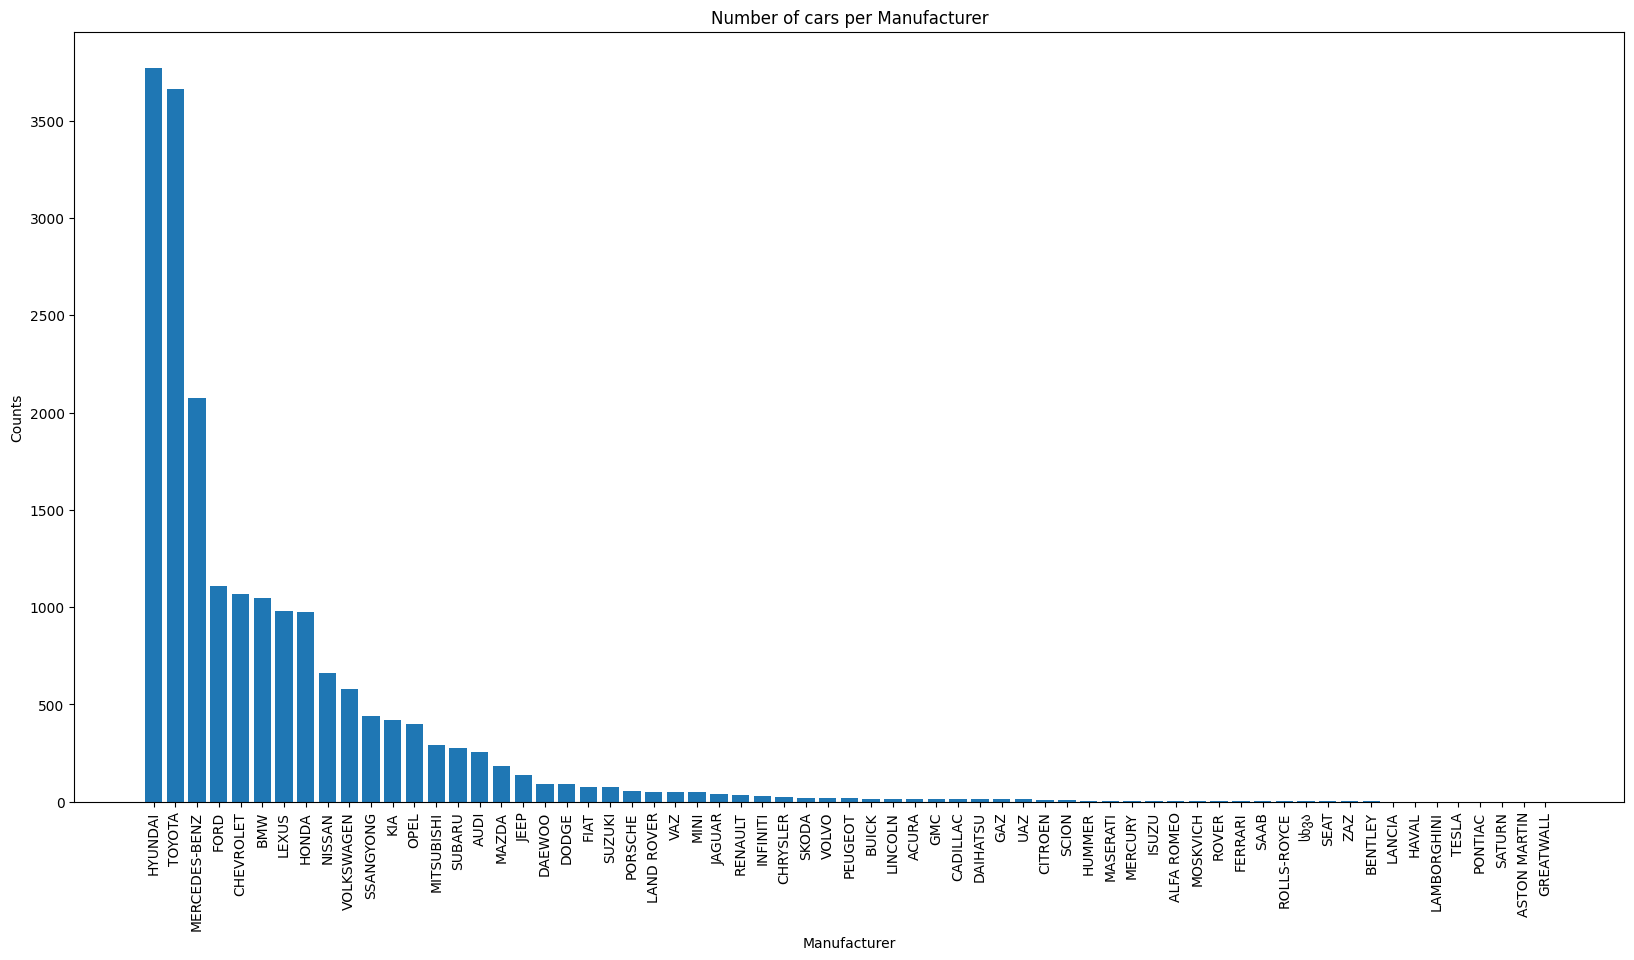

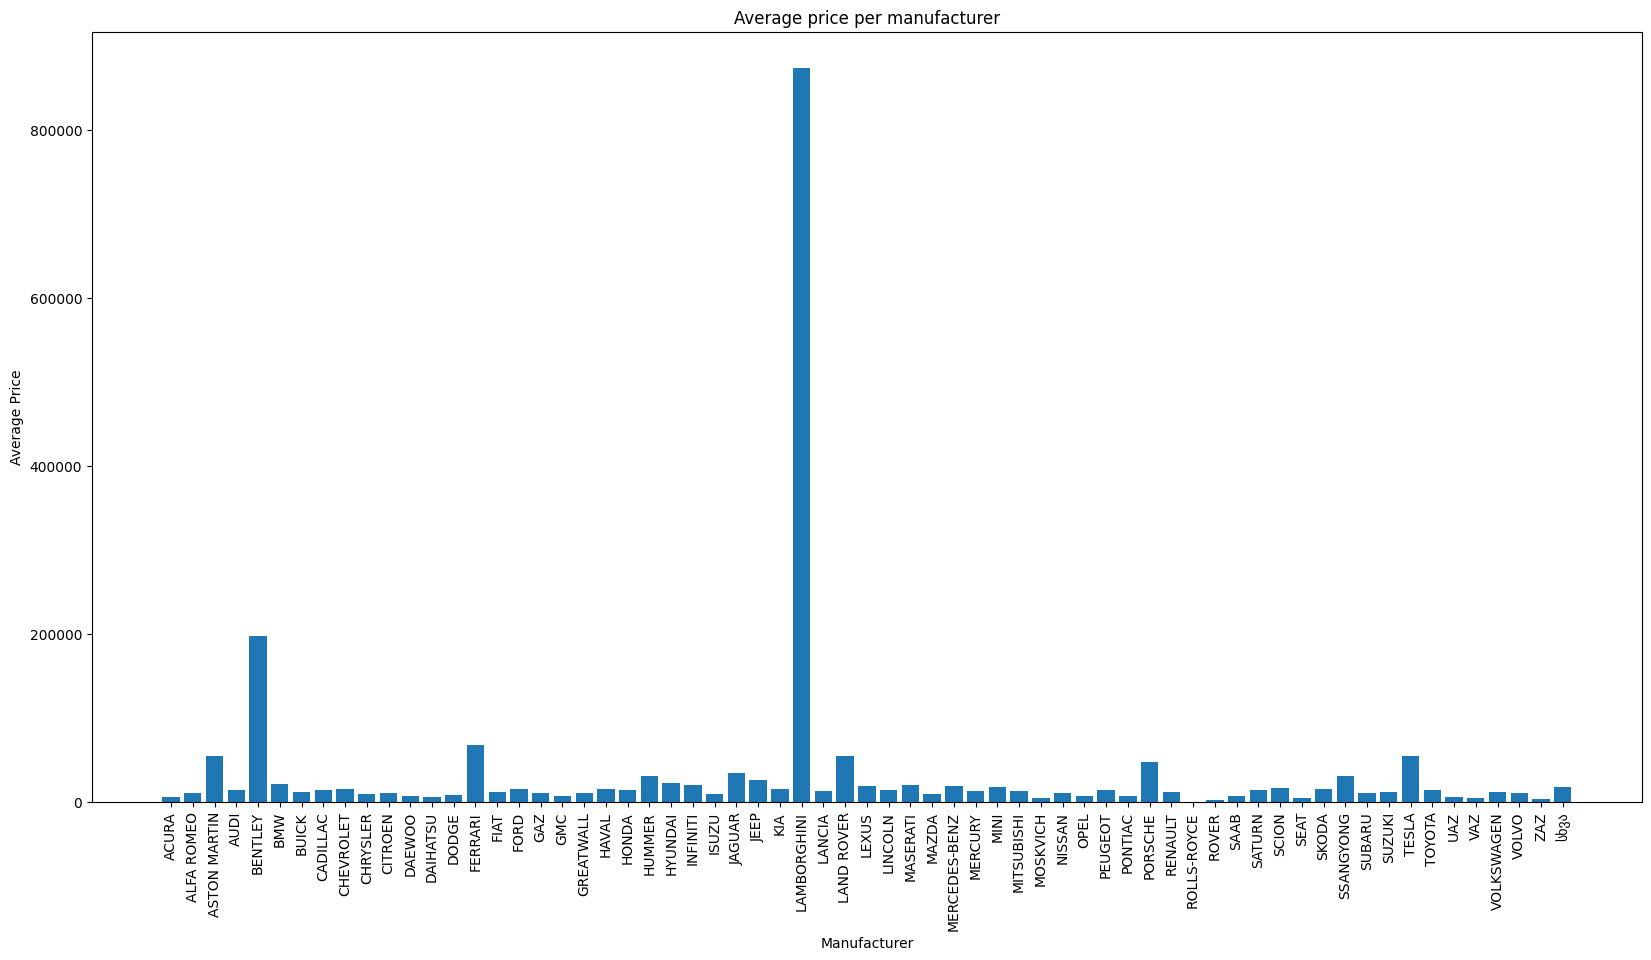

In [20]:
input_file_path = "car_price_prediction.csv"
output_file_path = "car_price_prediction_processed.csv"
data, scaler = preprocess_data(input_file_path, output_file_path)

#### Setting Up the Data:

- **Feature Selection**: Our target variable for prediction is the `Price` of cars. Thus, it's separated from the rest of the features to set up our `X` (independent features) and `y` (dependent/target feature).

- **Train-Test Split**: It's paramount in machine learning to have separate sets of data for training and testing to ensure our model's generalization to unseen data. We've allocated 80% of our data to training (`X_train` & `y_train`) and the remaining 20% for testing (`X_test` & `y_test`). The `random_state` ensures reproducibility of results.

#### Feature Scaling:

- **Why Scale?**: Scaling ensures that all the features have a consistent scale, which is vital for algorithms that are sensitive to the magnitude of features.

- **Features to Scale**: Continuous features such as `"Levy"`, `"Engine volume"`, `"Mileage"`, `"Airbags"`, and `"Car Age"` are transformed using the scaler trained in the preprocessing step. This ensures consistency in scale when we use these features for modeling.

#### Model Preparation:

- **Model Selection**: Various models are considered to ensure robustness in predictions. We've initialized a dictionary of models using `get_models()` which includes algorithms like SGD Regression, Ridge Regression, Random Forest, and kNN.

- **Hyperparameter Spaces**: Each model may require tuning of certain parameters for optimal performance. `get_search_spaces()` provides the potential search spaces for hyperparameters of each model. For instance:
  - SGD Regression will explore various values for `alpha`.
  - Ridge Regression will test different levels of `alpha` for regularization.
  - Random Forest will experiment with `n_estimators`, `max_depth`, etc.
  - kNN will assess the impact of `n_neighbors` and the `weights` scheme.

- **Timing**: A `total_time` variable is initialized to zero, which will be used later to keep track of the time taken for model training and prediction.

In [22]:
X = data.drop(columns=["Price"])
y = data["Price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

continuous_features = ["Levy", "Engine volume", "Mileage", "Airbags", "Car Age"]
X_train[continuous_features] = scaler.transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

models_dict = get_models()
search_spaces = get_search_spaces()
total_time = 0

### SGD Regression Results

SGD Regression is a linear algorithm that uses Stochastic Gradient Descent to estimate the coefficients. For our car pricing dataset:

- **RMSE (Root Mean Square Error)**: 8761.945. This indicates that on average, the predicted car prices deviate by about 8761.945 units from the actual prices.
- **MAE (Mean Absolute Error)**: 6588.529. On average, the predicted prices are approximately 6588.529 units away from the actual price values.
- **MAPE (Mean Absolute Percentage Error)**: 10.70%. The predictions are off by 10.70% from the actual prices.
- **R2 Score**: 0.395. This implies that the model can explain about 39.5% of the variance in the car pricing.
- **Time**: It took approximately 107.138 seconds to train the SGD Regression model.


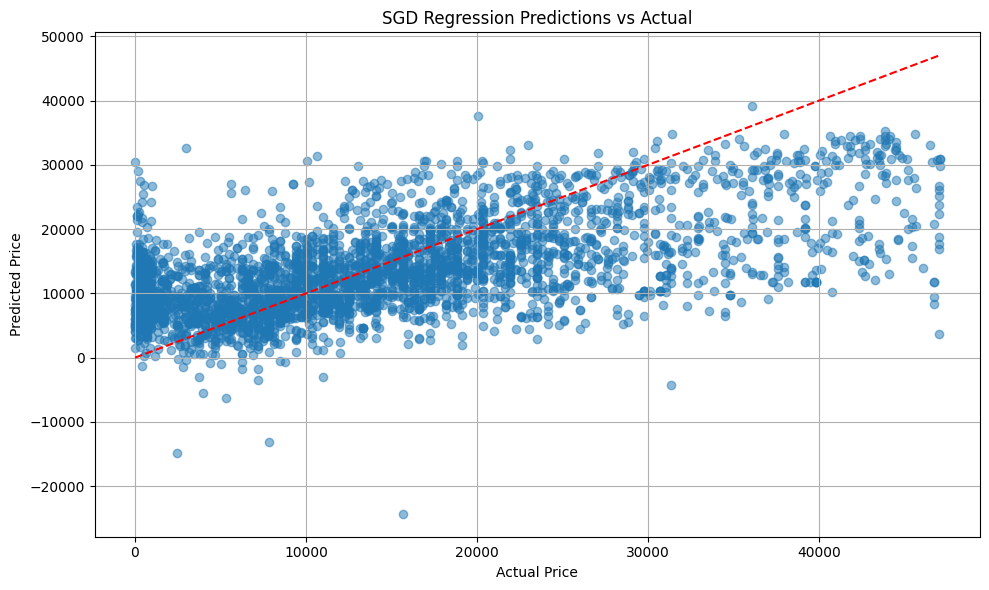

SGD Regression RMSE: 8761.945, MAE: 6588.529, MAPE: 10.70 %, R2 Score: 0.395, Time elapsed: 107.138s


In [67]:
start_time_model = timer()
# Extract the SGD Regression model and its hyperparameters
sgd_model = models_dict["SGD Regression"]
sgd_params = search_spaces["SGD Regression"]

# If there's hyperparameter tuning
search = GridSearchCV(sgd_model, sgd_params, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
best_sgd_model = search.best_estimator_

# Predict
sgd_predictions = best_sgd_model.predict(X_test)
end_time_model = timer()
total_model_time = end_time_model - start_time_model

rmse = mean_squared_error(y_test, sgd_predictions, squared=False)
mae = mean_absolute_error(y_test, sgd_predictions)
mape = mean_absolute_percentage_error(y_test, sgd_predictions)
r2 = r2_score(y_test, sgd_predictions)

plot_predictions(y_test, sgd_predictions, "SGD Regression")

print(
    f"SGD Regression RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f} %, R2 Score: {r2:.3f},"
    f" Time elapsed: {total_model_time:.3f}s"
)

### Random Forest

In [ ]:
start_time_model = timer()

# Extract the Random Forest model and its hyperparameters
rf_model = models_dict["Random Forest"]
rf_params = search_spaces["Random Forest"]

# Hyperparameter tuning
search = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
best_rf_model = search.best_estimator_

# Predictions
rf_predictions = best_rf_model.predict(X_test)

end_time_model = timer()
total_model_time = end_time_model - start_time_model

# Metrics
rmse = mean_squared_error(y_test, rf_predictions, squared=False)
mae = mean_absolute_error(y_test, rf_predictions)
mape = mean_absolute_percentage_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

plot_predictions(y_test, rf_predictions, "Random Forest")

importance = best_rf_model.feature_importances_
aggregated = aggregate_importance(importance, X_train.columns)
plot_aggregated_importance(aggregated)

print(
    f"Random Forest RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f} %, R2 Score: {r2:.3f},"
    f" Time elapsed: {total_model_time:.3f}s"
)


### Ridge Regression Results

Ridge Regression is a type of linear regression that includes a regularization term. The regularization term discourages overly complex models which can overfit the training data. Here are its results:

- **RMSE**: 8695.939. The predictions deviate from the actuals by an average of 8695.939 units.
- **MAE**: 6573.305. Predicted prices are, on average, 6573.305 units away from the true prices.
- **MAPE**: 11.51%. Predicted prices are off by 11.51% on average.
- **R2 Score**: 0.404. The model explains roughly 40.4% of the variance in the car pricing.
- **Time**: Training the Ridge Regression model took about 22.322 seconds.


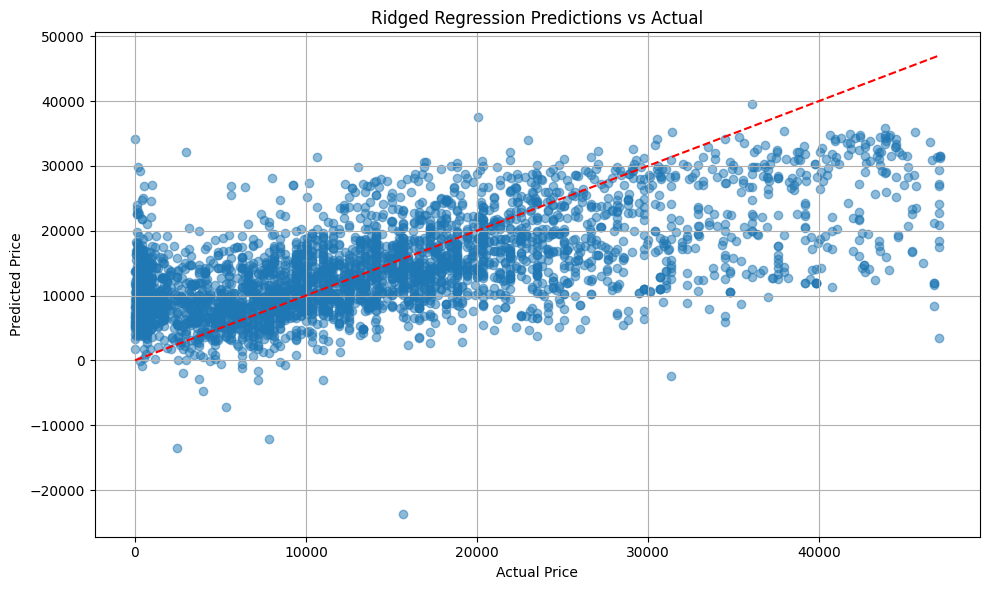

Ridge Regression RMSE: 8695.939, MAE: 6573.305, MAPE: 11.51 %, R2 Score: 0.404, Time elapsed: 22.322s


In [68]:
start_time_model = timer()

# Extract the Ridge Regression model and its hyperparameters
ridge_model = models_dict["Ridge Regression"]
ridge_params = search_spaces["Ridge Regression"]

# Hyperparameter tuning
search = GridSearchCV(ridge_model, ridge_params, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
best_ridge_model = search.best_estimator_

# Predictions
ridge_predictions = best_ridge_model.predict(X_test)

end_time_model = timer()
total_model_time = end_time_model - start_time_model

# Metrics
rmse = mean_squared_error(y_test, ridge_predictions, squared=False)
mae = mean_absolute_error(y_test, ridge_predictions)
mape = mean_absolute_percentage_error(y_test, ridge_predictions)
r2 = r2_score(y_test, ridge_predictions)

plot_predictions(y_test, ridge_predictions, "Ridged Regression")

print(
    f"Ridge Regression RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f} %, R2 Score: {r2:.3f},"
    f" Time elapsed: {total_model_time:.3f}s"
)


### kNN Results

K-Nearest Neighbors (KNN) is a non-parametric algorithm that predicts the value of a new observation based on the values of its closest observations in the training dataset. For the car pricing dataset:

- **RMSE**: 7157.238. Predicted prices deviate from the actuals by 7157.238 units on average.
- **MAE**: 4439.682. Predicted values are around 4439.682 units away from the actual prices.
- **MAPE**: 6.36%. The model's predictions are off by an average of 6.36%.
- **R2 Score**: 0.596. This suggests that the KNN model can explain about 59.6% of the variance in the car prices.
- **Time**: The KNN model took about 114.066 seconds for training.


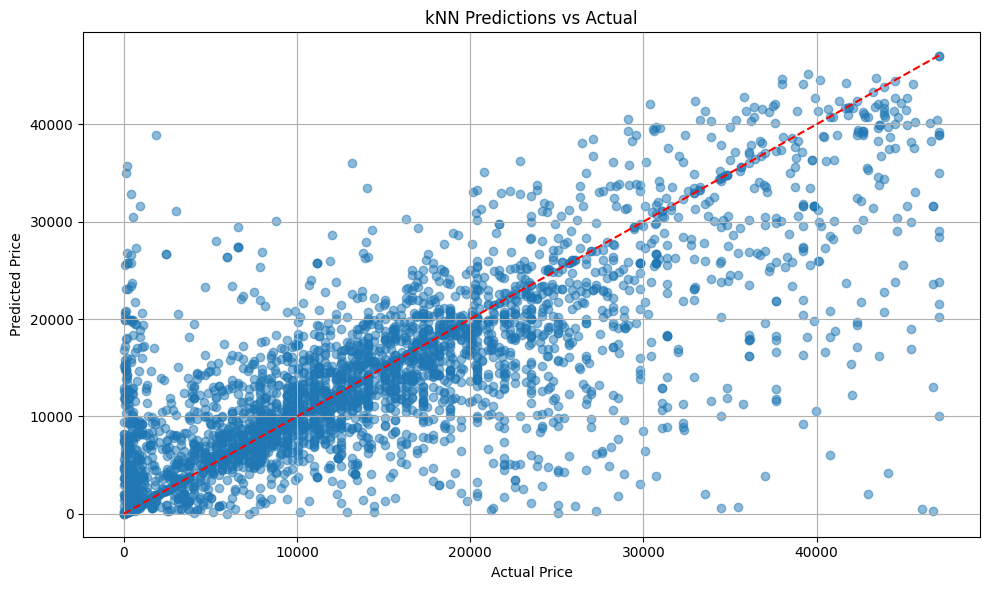

KNN RMSE: 7157.238, MAE: 4439.682, MAPE: 6.36 %, R2 Score: 0.596, Time elapsed: 114.066s


In [69]:
start_time_model = timer()

# Extract the KNN model and its hyperparameters
knn_model = models_dict["kNN"]
knn_params = search_spaces["kNN"]

# Hyperparameter tuning
search = GridSearchCV(knn_model, knn_params, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
best_knn_model = search.best_estimator_

# Predictions
knn_predictions = best_knn_model.predict(X_test)

end_time_model = timer()
total_model_time = end_time_model - start_time_model

# Metrics
rmse = mean_squared_error(y_test, knn_predictions, squared=False)
mae = mean_absolute_error(y_test, knn_predictions)
mape = mean_absolute_percentage_error(y_test, knn_predictions)
r2 = r2_score(y_test, knn_predictions)

plot_predictions(y_test, knn_predictions, "kNN")

print(
    f"KNN RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2f} %, R2 Score: {r2:.3f},"
    f" Time elapsed: {total_model_time:.3f}s"
)
